In [1]:
from __future__ import print_function
import time
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import deepcopy
from sklearn import datasets
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

print('TF: ', tf.__version__)
print('Keras: ', keras.__version__)

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible

digits = datasets.load_digits()
X = digits.data.astype(np.float32)/16.0 - 0.5
y = digits.target.astype(np.int32)

X = X.reshape((X.shape[0],1,8,8)) # reshape as images

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

TF:  2.2.0
Keras:  2.3.0-tf


(1437, 1, 8, 8)

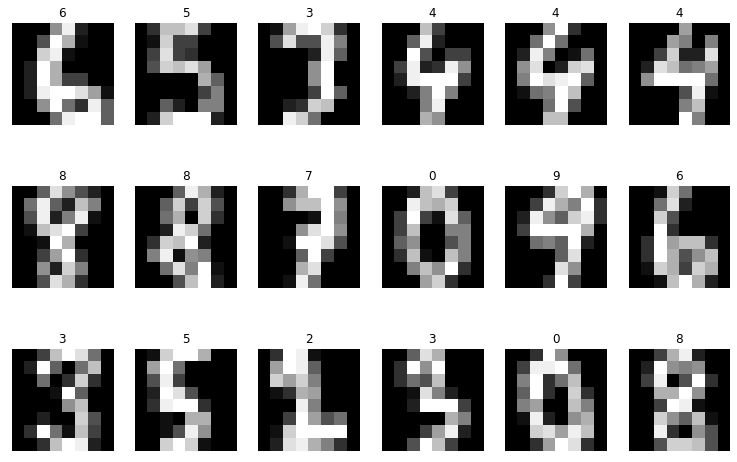

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(1437, 1, 8, 8)
(360, 1, 8, 8)


In [4]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, batch_size=32, epochs=150, shuffle=True, verbose=0)

CPU times: user 28.5 s, sys: 5.74 s, total: 34.2 s
Wall time: 37.6 s


In [5]:
%%time

cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,8,8), data_format="channels_first") )

cnn.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
cnn.add( Activation('relu') )

cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 8)          80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 4, 4)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 16, 4, 4)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 2,650
Trainable params: 2,650
Non-trainable params: 0
____________________________________________________

In [6]:
%%time 

print(X_train.shape)

cnn.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

cnn.fit(X_train, y_train_ohe, batch_size=32, epochs=150, shuffle=True, verbose=0)

(1437, 1, 8, 8)
CPU times: user 28.2 s, sys: 7.2 s, total: 35.4 s
Wall time: 30.3 s


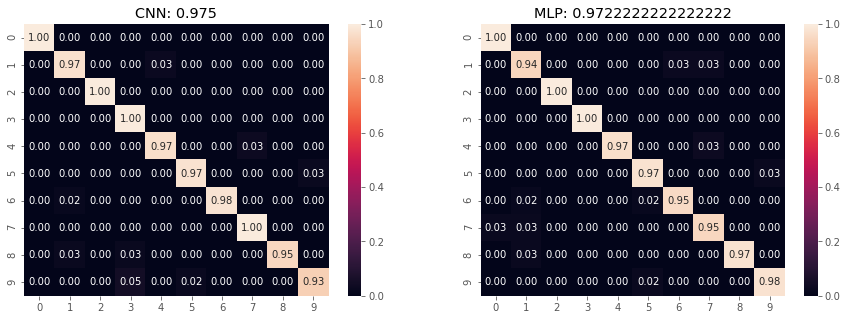

In [7]:
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))
        
compare_mlp_cnn(cnn,mlp,X_test,y_test)

CPU times: user 28 s, sys: 7.46 s, total: 35.5 s
Wall time: 23.8 s


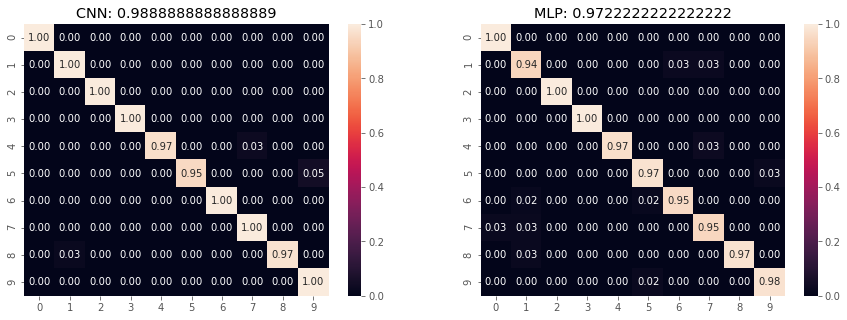

In [8]:
%%time

cnn2 = Sequential()
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,8,8), data_format="channels_first") )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )

cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

cnn2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

cnn2.fit(X_train, y_train_ohe, batch_size=32, epochs=150, shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

CPU times: user 32.9 s, sys: 11.8 s, total: 44.6 s
Wall time: 35.4 s


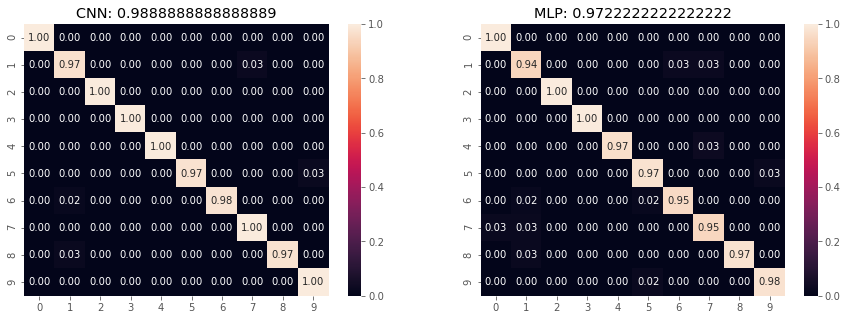

In [9]:
%%time


cnn3 = Sequential()

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, kernel_size=(3,3), padding='same', data_format="channels_first") )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    

cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

cnn3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

cnn3.fit(X_train, y_train_ohe, batch_size=32, epochs=150, shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

CPU times: user 36 s, sys: 12.2 s, total: 48.1 s
Wall time: 38.1 s


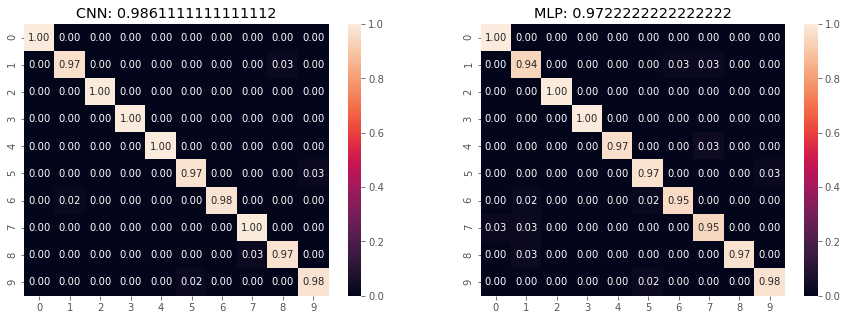

In [10]:
%%time

cnn4 = Sequential()

num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, kernel_size=(3,3), padding='same',data_format="channels_first"))
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

cnn4.fit(X_train, y_train_ohe, batch_size=32, epochs=150, shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

In [11]:
import os
import struct
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
X_test, y_test = load_mnist('data/', kind='fashion_t10k')

X_train = X_train.reshape(X_train.shape[0],1,28,28)/255.0 - 0.5
X_test = X_test.reshape(X_test.shape[0],1,28,28)/255.0 - 0.5

print('X_train shape:', X_train.shape) 
print('X_test shape:', X_test.shape)

NUM_CLASSES = 10

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train shape: (60000, 1, 28, 28)
X_test shape: (10000, 1, 28, 28)


In [12]:
%%time

mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe,batch_size=32, epochs=15,shuffle=True, verbose=1)

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5075 - accuracy: 0.8133
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3878 - accuracy: 0.8599
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3542 - accuracy: 0.8714
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3353 - accuracy: 0.8787
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3246 - accuracy: 0.8831
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3209 - accuracy: 0.8859
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3157 - accuracy: 0.8885
Epoch 8/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3177 - accuracy: 0.8890
Epoch 9/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3123 - accuracy: 0.8911
Epoch 10/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.308

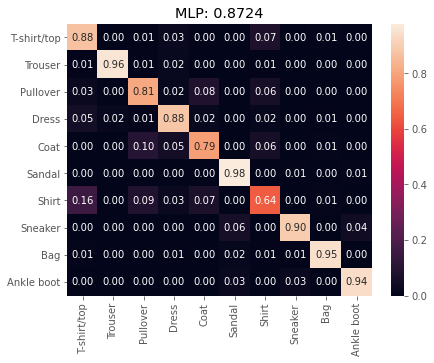

In [13]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
compare_mlp_cnn(None,mlp,X_test,y_test,labels)

Epoch 1/15
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0233 - accuracy: 0.8349 - val_loss: 0.0182 - val_accuracy: 0.8741
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0156 - accuracy: 0.8927 - val_loss: 0.0150 - val_accuracy: 0.8946
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0135 - accuracy: 0.9078 - val_loss: 0.0153 - val_accuracy: 0.8961
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0122 - accuracy: 0.9170 - val_loss: 0.0147 - val_accuracy: 0.9018
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0112 - accuracy: 0.9248 - val_loss: 0.0137 - val_accuracy: 0.9091
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0105 - accuracy: 0.9302 - val_loss: 0.0150 - val_accuracy: 0.8986
Epoch 7/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0097 - accuracy: 0.9356 - val_loss: 0.0142 - val_accurac

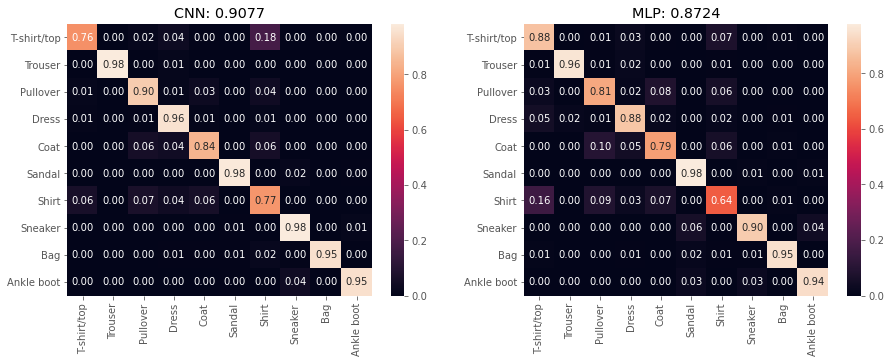

In [14]:
%%time

cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',data_format="channels_first") )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2),data_format="channels_first") )
    
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['accuracy'])


cnn1.fit(X_train, y_train_ohe, batch_size=32, epochs=15, shuffle=True, verbose=1,validation_data=(X_test,y_test_ohe))

compare_mlp_cnn(cnn1,mlp,X_test,y_test,labels)

Epoch 1/10
938/938 [==============================] - 23s 25ms/step - loss: 0.4308 - accuracy: 0.8440 - val_loss: 0.3156 - val_accuracy: 0.8850
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2881 - accuracy: 0.8970 - val_loss: 0.2881 - val_accuracy: 0.8970
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2614 - accuracy: 0.9064 - val_loss: 0.2886 - val_accuracy: 0.9054
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2483 - accuracy: 0.9129 - val_loss: 0.2787 - val_accuracy: 0.9050
Epoch 5/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2411 - accuracy: 0.9152 - val_loss: 0.2617 - val_accuracy: 0.9120
Epoch 6/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2378 - accuracy: 0.9167 - val_loss: 0.2555 - val_accuracy: 0.9099
Epoch 7/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2369 - accuracy: 0.9172 - val_loss: 0.3234 - val_accuracy:

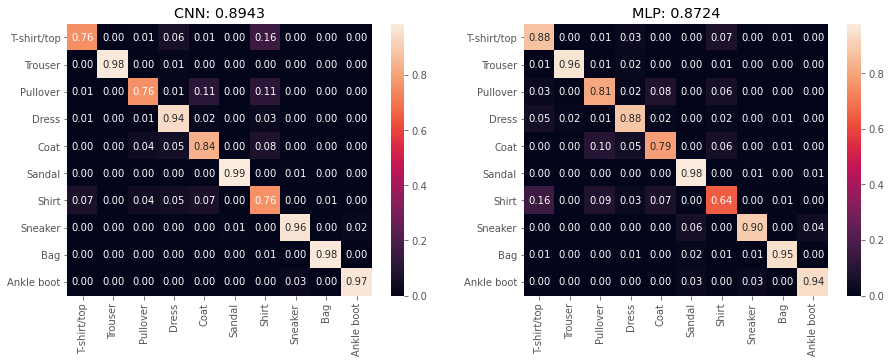

In [15]:
%%time

cnn2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',activation='relu',data_format="channels_first") )
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )


cnn2.add( Dropout(0.25) )
cnn2.add( Flatten() )
cnn2.add( Dense(1024, activation='relu') )
cnn2.add( Dropout(0.5) )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

cnn2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

cnn2.fit(X_train, y_train_ohe, batch_size=64, epochs=10, shuffle=True, verbose=1, validation_data=(X_test,y_test_ohe))

compare_mlp_cnn(cnn2,mlp,X_test,y_test,labels)

In [16]:
cnn2.evaluate(X_test,y_test_ohe,verbose=0)

[0.335597425699234, 0.8942999839782715]

In [17]:
cnn2.save('data/mnist_cnn.h5')

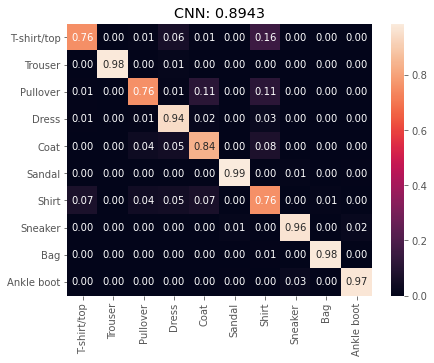

In [18]:
from tensorflow.keras.models import load_model

cnn_mnist = load_model('data/mnist_cnn.h5')
compare_mlp_cnn(cnn_mnist,None,X_test,y_test,labels)